In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import keras
from keras import backend as K
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Concatenate
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.losses import categorical_crossentropy
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.optimizers import Adadelta, Nadam, Adam
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.python.client import device_lib
import utils
import imp
imp.reload(utils)

IMAGE_HEIGHT, IMAGE_WIDTH = 120, 120
AGE_CLASSES = 100
MAX_SURVIVAL = 2000

Using TensorFlow backend.


## Load data

In [2]:
df = pd.read_csv("data/survival_data.csv")
df.head()
orig_X = np.load('data/tumors_small_nz.npy')
orig_X = orig_X.transpose((0, 2, 1, 3, 4))
X = orig_X
Y = df['Survival']

## Tumor 2D

One pixel contains the sum of slices containing tumor at this position

In [3]:
tumor2D = orig_X[:, :, :, :, :].sum(axis=2)
X = tumor2D

In [ ]:
# Example how this will look in the end, the values are between 0 and 16000
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(orig_X[10, i, :, :, :].sum(axis=0))
    ax.set_title('Patient 10, Tumor region {}'.format(i))
axes[-1].set_title('Patient 10, Brain modality #1')
fig.savefig('analysis/tumor_2d.jpg')

## Prepare data

In [4]:
def get_splitted_data(X, ages, labels):
    assert len(X) == len(labels) == len(ages)
    # OneHotEncoding for ages
    enc_table = np.eye(AGE_CLASSES)
    ages_ohe = np.array([enc_table[int(round(x))] for x in ages])
    # Normalize labels
    labels /= MAX_SURVIVAL
    # Use all data for training and testing:
    cuts = [int(.9*len(X))]
    X1_train, X1_test = np.split(X, cuts)
    X2_train, X2_test = np.split(ages_ohe, cuts)
    Y_train, Y_test = np.split(labels, cuts)
    return X1_train, X2_train, Y_train, X1_test, X2_test, Y_test

X1_train, X2_train, Y_train, X1_test, X2_test, Y_test = get_splitted_data(X, df['Age'], Y)

## Run model

In [8]:
def mse(y_true, y_pred):
    return K.mean(K.square(y_pred*MAX_SURVIVAL - y_true*MAX_SURVIVAL), axis=-1)

def build_model():
    main_input = Input(shape=X1_test.shape[1:], dtype='float32', name='main_input')
    x = Conv2D(32, (5, 5), padding='same', data_format='channels_first')(main_input)
    x = MaxPooling2D(pool_size=(2, 2), data_format='channels_first')(x)
    x = Activation(LeakyReLU())(x)
    x = Dropout(0.5)(x)
    x = Conv2D(64, (3, 3), padding='same', data_format='channels_first')(x)
    x = MaxPooling2D(pool_size=(2, 2), data_format='channels_first')(x)
    x = Activation(PReLU())(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='tanh')(x)
    cnn_out = Flatten()(x)
    x = Dense(64, activation='sigmoid')(x)
    auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(cnn_out)

    auxiliary_input = Input(shape=(AGE_CLASSES,), name='aux_input', dtype='float32')
    x = Dense(AGE_CLASSES//2, activation='tanh')(auxiliary_input)
    x = Dropout(0.3)(x)
    x = keras.layers.concatenate([cnn_out, x])
    x = Dense(128, activation='tanh')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='sigmoid')(x)
    main_output = Dense(1, dtype='float32', activation='sigmoid', name='main_output')(x)
    model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])
    optimizer = 'Adam'  # Adam(lr=0.001)
    model.compile(optimizer=optimizer, metrics=[mse],
                  loss={'main_output': 'mean_squared_error', 'aux_output': 'mean_squared_error'},
                  loss_weights={'main_output': 1, 'aux_output': 0})
    return model

In [9]:
def train_model(train, test, epochs=50, verbose=1, batch_size=16):
    input1_train, input2_train, output_train = train
    input1_test, input2_test, output_test = test
    with tf.device('/gpu:0'):
        model = build_model()
        history = keras.callbacks.History()
        try:
            model_results = model.fit(
                {'main_input': input1_train, 'aux_input': input2_train},
                {'main_output': output_train, 'aux_output': output_train},
                epochs=epochs, batch_size=batch_size, verbose=verbose,
                validation_data=({'main_input': input1_test, 'aux_input': input2_test},
                                 {'main_output': output_test, 'aux_output': output_test}),
                callbacks=[history])
        except KeyboardInterrupt:
            model_results = None
            pass
    return model, model_results

model, model_results = train_model((X1_train, X2_train, Y_train), (X1_test, X2_test, Y_test))

Train on 146 samples, validate on 17 samples
Epoch 1/50
146/146 [==============================] - 14s - loss: 0.0629 - main_output_loss: 0.0629 - aux_output_loss: 0.2399 - main_output_mse: 251758.9489 - aux_output_mse: 959706.9914 - val_loss: 0.0274 - val_main_output_loss: 0.0274 - val_aux_output_loss: 0.2118 - val_main_output_mse: 109456.0044 - val_aux_output_mse: 847179.8750
Epoch 2/50
146/146 [==============================] - 13s - loss: 0.0315 - main_output_loss: 0.0315 - aux_output_loss: 0.2020 - main_output_mse: 125803.9405 - aux_output_mse: 808127.7483 - val_loss: 0.0330 - val_main_output_loss: 0.0330 - val_aux_output_loss: 0.1755 - val_main_output_mse: 131920.0647 - val_aux_output_mse: 702179.3235
Epoch 3/50
146/146 [==============================] - 13s - loss: 0.0329 - main_output_loss: 0.0329 - aux_output_loss: 0.2141 - main_output_mse: 131749.2000 - aux_output_mse: 856439.5488 - val_loss: 0.0291 - val_main_output_loss: 0.0291 - val_aux_output_loss: 0.1623 - val_main_outpu

AttributeError: 'NoneType' object has no attribute 'history'

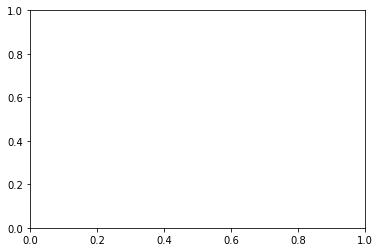

In [10]:
# imp.reload(utils)
utils.plot_history(model_results, filename='analysis/model_history.jpg')
utils.plot_model(model, 'analysis/model.jpg')

# Evaluate model on validation set
val_score = model.evaluate({'main_input': X1_test, 'aux_input': X2_test},
                                           {'main_output': Y_test, 'aux_output': Y_test}, verbose=0)
print('Test mse:', val_score[-2])
print('Predictions on training set: ')
predicted = model.predict({'main_input': X1_train, 'aux_input': X2_train})
print(np.unique(np.round(np.array(predicted)[0, :, 0] * MAX_SURVIVAL)))
print(np.unique(np.round(np.array(predicted)[1, :, 0] * MAX_SURVIVAL)))

In [ ]:
# N-fold cross validation
# 1.) http://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
# 2.) https://datascience.stackexchange.com/questions/11747/cross-validation-in-keras
results = []
best_model = None
best_value = None
best_model_results = None
def n_fold_cross_validation(folds=10):
    global best_model, best_value
    step = float(X.shape[0]) / folds
    enc_table = np.eye(AGE_CLASSES)
    ages_ohe = np.array([enc_table[int(round(x))] for x in df['Age']])
    # Normalize labels
    labels = df['Survival'] / MAX_SURVIVAL
    for i in range(folds):
        cuts = [int(step*i), int(step*(i+1))]
        X1_train_front, X1_test, X1_train_back = np.split(X, cuts)
        X2_train_front, X2_test, X2_train_back = np.split(ages_ohe, cuts)
        Y_train_front, Y_test, Y_train_back = np.split(labels, cuts)
        X1_train = np.concatenate([X1_train_front, X1_train_back])
        X2_train = np.concatenate([X2_train_front, X2_train_back])
        Y_train = np.concatenate([Y_train_front, Y_train_back])
        print("Train model...")
        model, model_results = train_model((X1_train, X2_train, Y_train), (X1_test, X2_test, Y_test), epochs=20, verbose=0)
        if model_results is None:
            # Cause by KeyboardInterrupt
            return results, None
        val_score = model.evaluate({'main_input': X, 'aux_input': ages_ohe},
                                   {'main_output': labels, 'aux_output': labels}, verbose=0)
        predicted = model.predict({'main_input': X, 'aux_input': ages_ohe})
        unique_values = np.unique([str(x) for x in np.round(np.array(predicted)[0, :, 0] * MAX_SURVIVAL)])
        print('Overall mse: ', val_score)
        if (len(unique_values) > 5 and val_score[-2] < 150000) or best_value is None or val_score[-2] < best_value:
            best_value = val_score[-2]
            best_model = model
            best_model_results = model_results
            print("Updated best model")
        
        val_score = model.evaluate({'main_input': X1_test, 'aux_input': X2_test},
                                   {'main_output': Y_test, 'aux_output': Y_test}, verbose=0)
        predicted = model.predict({'main_input': X1_test, 'aux_input': X2_test})
        unique_values = np.unique([str(x) for x in np.round(np.array(predicted)[0, :, 0] * MAX_SURVIVAL)])
        print("Test MSE in run {}: {}, {}".format(i, val_score[-2], val_score[-1]))
        print("Unique predicted values: {}".format(' '.join(unique_values)))
        results.append(val_score[-2])
    return results, np.mean([x**2 for x in results])

results_output, cv_mse = n_fold_cross_validation()

Train model...
('Overall mse: ', [0.030425029358272355, 0.030425029358272355, 0.042007312287170827, 121700.12441286426, 168029.24345763036])
Updated best model
Test MSE in run 0: 125325.953125, 155156.21875
Unique predicted values: 410.0
Train model...
('Overall mse: ', [0.031110583647422814, 0.031110583647422814, 0.045526761241668573, 124442.34972919861, 182107.04570072851])
Test MSE in run 1: 80217.578125, 185455.578125
Unique predicted values: 369.0
Train model...
('Overall mse: ', [0.030396757750240571, 0.030396757750240571, 0.080628844652256351, 121587.0366660276, 322515.38333972392])
Updated best model
Test MSE in run 2: 174269.0625, 311833.8125
Unique predicted values: 431.0
Train model...


In [670]:
def mse(X1, X2, Y, verbose=False):
    sum_ = 0
    for i in range(len(X1)):
        prediction = best_model.predict({'main_input': X1[i:i+1], 'aux_input': X2[i:i+1]})
        prediction = prediction[0][0][0] * MAX_SURVIVAL  # Select main_output
        gt = Y.values[i] * MAX_SURVIVAL
        if verbose:
            print('Age: {}, GT: {}, Prediction: {}'.format(
                X2[i].argmax(),
                gt,
                prediction))
        sum_ += float(gt - prediction)**2
    return 'MSE: {}'.format(sum_ / len(X1))

print('train: {}'.format(mse(X1_train, X2_train, Y_train)))
print('test: {}'.format(mse(X1_test, X2_test, Y_test, verbose=True)))
print('val: {}'.format(mse(X1_val, X2_val, Y_val, verbose=True)))

train: MSE: 124767.550882
Age: 58, GT: 439.0, Prediction: 384.124279022
Age: 56, GT: 368.0, Prediction: 384.124279022
Age: 63, GT: 169.0, Prediction: 384.124279022
Age: 52, GT: 359.0, Prediction: 384.124279022
Age: 60, GT: 698.0, Prediction: 384.124279022
Age: 66, GT: 495.0, Prediction: 384.124279022
Age: 61, GT: 421.0, Prediction: 384.124279022
Age: 48, GT: 515.0, Prediction: 384.124279022
Age: 56, GT: 1155.0, Prediction: 384.124279022
Age: 68, GT: 1278.0, Prediction: 384.124279022
Age: 70, GT: 503.0, Prediction: 384.124279022
Age: 67, GT: 269.0, Prediction: 384.124279022
Age: 68, GT: 465.0, Prediction: 384.124279022
Age: 39, GT: 788.0, Prediction: 384.124279022
Age: 54, GT: 464.0, Prediction: 384.124279022
Age: 52, GT: 616.0, Prediction: 384.124279022
Age: 60, GT: 289.0, Prediction: 384.124279022
test: MSE: 108175.323335


ZeroDivisionError: integer division or modulo by zero

## Evaluate network on validation data

In [ ]:
val_df = pd.read_csv("val_data/survival_evaluation.csv")
val_orig_X = np.load('data/val_tumors_small_nz.npy').transpose((0, 2, 1, 3, 4))
enc_table = np.eye(AGE_CLASSES)
X1_val = val_orig_X[:, :, :, :, :].sum(axis=2)
X2_val = np.array([enc_table[int(round(x))] for x in val_df['Age']])
prediction = model.predict({'main_input': X1_val, 'aux_input': X2_val})
prediction = np.array(prediction)[0, :, 0]

val_output = pd.DataFrame(columns=['Brats17ID', 'Output', 'Survival'])
val_output['Brats17ID'] = val_df['Brats17ID']
val_output['Output'] = prediction
val_output['Survival'] = prediction * MAX_SURVIVAL
val_output.to_csv('analysis/val_results.csv' ,index=False)

In [ ]:
!head val_data/survival_evaluation.csv